In [1]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import numpy as np
import gcsfs
import time
from dask.diagnostics import ProgressBar
from dask import dataframe as dd
from google.cloud import bigquery, storage
from time import gmtime, strftime
from datetime import datetime, timedelta
from tqdm import tqdm

from helpers.dimensions import form_dim, update_dim, map_dim
from helpers.data_etl import df_from_bq, df_to_bq, dml_for_bq
from clients.appsflyer import AppsFlyer

import warnings

warnings.filterwarnings("ignore")

primary_token = "29d85f91-d29b-4b43-a62d-e65b0633efef"
app_id = "id1459969523"
af = AppsFlyer(api_token=primary_token, app_id=app_id)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
installs = pd.DataFrame()
for d in tqdm(
    pd.date_range(
        (datetime.now().date() - timedelta(days=20)).isoformat(),
        (datetime.now().date() - timedelta(days=1)).isoformat(),
        freq="5D",
    ).tolist()
):
    resp = af.fraud_installs_report(
        date_from=d.strftime("%Y-%m-%d"),
        date_to=(d + timedelta(days=4)).strftime("%Y-%m-%d"),
        as_df=True,
    )
    if len(resp) > 199999:
        print(d)

    installs = pd.concat([installs, resp])
    time.sleep(1)
r = installs.copy()

100%|██████████| 4/4 [01:02<00:00, 15.70s/it]


In [3]:
iaps = pd.DataFrame()
for d in tqdm(
    pd.date_range(
        (datetime.now().date() - timedelta(days=11)).isoformat(),
        (datetime.now().date() - timedelta(days=1)).isoformat(),
        freq="1D",
    ).tolist()
):
    resp = af.fraud_in_app_events_report(
        date_from=d.strftime("%Y-%m-%d"),
        date_to=(d + timedelta(days=1)).strftime("%Y-%m-%d"),
        as_df=True,
    )
    if len(resp) > 199999:
        print(d)

    iaps = pd.concat([iaps, resp])
    time.sleep(1)
i = iaps.copy()

100%|██████████| 11/11 [22:27<00:00, 122.49s/it]


In [4]:
installs = installs[
    [
        "Attributed Touch Type",
        "Install Time",
        "Event Name",
        "Event Value",
        "Media Source",
        "Campaign",
        "Ad",
        "Country Code",
        "AppsFlyer ID",
        "IDFA",
        "Blocked Reason",
        "Blocked Reason Value",
        "Blocked Reason Rule",
        "Blocked Sub Reason",
        "Contributor 1 Campaign",
        "Contributor 2 Campaign",
        "Contributor 3 Campaign",
        "Match Type",
    ]
]

In [ ]:
iaps = i.copy()
iaps = iaps[
    [
        "Attributed Touch Type",
        "Install Time",
        "Event Time",
        "Event Name",
        "Event Value",
        "Media Source",
        "Campaign",
        "Ad",
        "Country Code",
        "AppsFlyer ID",
        "IDFA",
        "Blocked Reason",
        "Blocked Reason Value",
        "Blocked Reason Rule",
        "Blocked Sub Reason",
        "Contributor 1 Campaign",
        "Contributor 2 Campaign",
        "Contributor 3 Campaign",
        "Match Type",
    ]
]

In [ ]:
iaps

Attributed Touch Type         Install Time           Event Time  \
0                     click  2020-10-23 23:55:42  2020-10-23 23:59:57   
1                     click  2020-10-12 07:55:15  2020-10-23 23:59:55   
2                     click  2020-10-12 07:55:15  2020-10-23 23:59:46   
3                     click  2020-10-22 22:27:07  2020-10-23 23:59:46   
4                     click  2020-10-23 23:55:42  2020-10-23 23:59:46   
...                     ...                  ...                  ...   
68047                 click  2020-10-12 18:17:47  2020-11-01 00:00:07   
68048                 click  2020-10-27 23:07:47  2020-11-01 00:00:04   
68049                 click  2020-10-08 14:02:02  2020-11-01 00:00:02   
68050                 click  2020-10-08 14:02:02  2020-11-01 00:00:02   
68051                 click  2020-10-21 04:32:59  2020-11-01 00:00:00   

                      Event Name               Event Value    Media Source  \
0       zodiac_today_screen_open     {"zodiac_sign":"Léo"}  adsbalance_int   
1          zodiac_me_screen_open                        {}  adsbalance_int   
2       subscription_screen_open                        {}  adsbalance_int   
3       subscription_screen_open                        {}  adsbalance_int   
4       zodiac_today_screen_open     {"zodiac_sign":"Léo"}  adsbalance_int   
...                          ...                       ...             ...   
68047                     launch     {"session_count":"9"}  adsbalance_int   
68048  compatibility_screen_open                        {}  adsbalance_int   
68049   subscription_screen_open                        {}    myappfre_int   
68050   zodiac_today_screen_open  {"zodiac_sign":"Chanté"}    myappfre_int   
68051   subscription_screen_open                        {}  adsbalance_int   

          Campaign   Ad Country Code           AppsFlyer ID  \
0      TF_CaAu_MoB  NaN           CA  1603497278269-2442970   
1         DP_LM_US  NaN           US  1602489302943-8265977   
2         DP_LM_US  NaN           US  1602489302943-8265977   
3       TF_US_MoBW  NaN           US  1603405579393-5062618   
4      TF_CaAu_MoB  NaN           CA  1603497278269-2442970   
...            ...  ...          ...                    ...   
68047    TF_US_Pap  NaN           US  1602526376175-2759194   
68048     TF_US_HW  NaN           US  1603840006921-9128194   
68049    TF_US_MaF  NaN           US  1602165483160-4912234   
68050    TF_US_MaF  NaN           US  1602165483160-4912234   
68051   TF_US_MoBW  NaN           US  1603070614922-7930648   

                                       IDFA Blocked Reason  \
0      09B6D35E-D1B7-4601-9357-5CE249E48E4B    click_flood   
1      3598F2E1-CB50-4AB2-B085-59CE46394D92    click_flood   
2      3598F2E1-CB50-4AB2-B085-59CE46394D92    click_flood   
3      A3E95636-A07A-4609-9AAB-315D1546BBD4    click_flood   
4      09B6D35E-D1B7-4601-9357-5CE249E48E4B    click_flood   
...                                     ...            ...   
68047  05D0ACA9-5FED-4C80-8A95-9A1C96361748    click_flood   
68048  3264D555-E29B-4920-85A9-09CEE8BAEBED    click_flood   
68049                                   NaN    click_flood   
68050                                   NaN    click_flood   
68051  5B37FFA2-E2BD-4597-AA16-2242BEE33993    click_flood   

      Blocked Reason Value  Blocked Reason Rule Blocked Sub Reason  \
0                      NaN                  NaN        click_flood   
1                      NaN                  NaN        click_flood   
2                      NaN                  NaN        click_flood   
3                      NaN                  NaN        click_flood   
4                      NaN                  NaN        click_flood   
...                    ...                  ...                ...   
68047                  NaN                  NaN        click_flood   
68048                  NaN                  NaN        click_flood   
68049                  NaN                  NaN        click

In [ ]:
iaps.groupby(['Blocked Reason','Blocked Sub Reason']).agg({'AppsFlyer ID':'nunique','Event Name':'count'})

AppsFlyer ID  Event Name
Blocked Reason    Blocked Sub Reason                               
bots              device_emulators                   25        1078
                  fake_device_parameters              1          14
                  fake_install_parameters             5         457
                  timestamp_anomalies              2038       82350
click_flood       click_flood                     21874     1489263
ctit_anomalies    ctit_anomalies                      1          49
                  short_ctit                        134       12092
install_hijacking click_clusters                     86        7171
site_blacklist    device_emulators                    1         376
                  device_farms                     2143       84304

In [ ]:
iaps.groupby('Event Name').size().reset_index(name='cnt').sort_values(by='cnt',ascending=False)

Event Name     cnt
176                           zodiac_today_screen_open  207378
163                           subscription_screen_open   99894
35                              birth_date_screen_open   65611
66                           compatibility_screen_open   65240
78                                              launch   63543
127                           relationship_screen_open   59390
3                                         ad_watch_tap   45138
177                        zodiac_tomorrow_screen_open   42197
79                                   launch_first_time   42146
168                                welcome_screen_open   42046
37                              birth_time_screen_open   41557
172                              zodiac_me_screen_open   41225
75                                  gender_screen_open   38749
88                                    name_screen_open   38326
77                               interests_screen_open   38023
68                          different_sign_screen_open   37508
137                            result_load_screen_open   36013
105                       palmistry_prompt_screen_open   35882
103                   palmistry_left_photo_screen_open   35367
109                                    push_enable_tap   35126
104                           palmistry_left_photo_tap   34771
106                               palmistry_prompt_tap   33813
0                          ad_compatibility_popup_open   31319
138                          review_request_popup_open   27338
67                    compatibitity_result_screen_open   27255
43                        chat_astrologers_screen_open   26566
178                            zodiac_week_screen_open   26216
174                           zodiac_month_screen_open   21192
82                                   learn_screen_open   20173
179                            zodiac_year_screen_open   19305
36                             birth_place_screen_open   17373
111                                   push_screen_open   17170
39                                   calendar_type_tap   15938
156                          special_offer_screen_open   14015
101                           newuser_section_redirect   12568
107                  palmistry_right_photo_screen_open   12387
108                          palmistry_right_photo_tap   10828
139                                screenshot_captured   10383
2                                     ad_request_error    9063
170                       zodiac_me_houses_screen_open    8897
110                                  push_open_success    8864
173                       zodiac_me_traits_screen_open    8512
42                 chat_astrologer_profile_screen_open    8391
159                                 subscription_error    6555
171                      zodiac_me_planets_screen_open    5993
154                                   shop_screen_open    5185
102                  palmistry_description_screen_open    4883
167                               text_my_relative_tap    4433
85                                    menu_screen_open    4215
155                               shop_sticker_get_tap    4188
165                             subscription_start_tap    4180
132          relationship_single_prev_relationship_tap    4170
97                                nebutalk_screen_open    4119
175                            zodiac_sign_screen_open    4087
153                            shop_poster_screen_open    3997
145                         shop_checklist_screen_open    3974
149                        shop_numerology_screen_open    3917
143                          shop_calendar_screen_open    3882
71                                       game_finished    3598
96                              nebutalk_nickname_open    3421
50                        chat_description_screen_open    3321
100                         nebutalk_topic_screen_open    3270
130              relationship_single_intro_screen_open    3088
131  relatio

(array([2.3602e+04, 2.2900e+03, 6.1300e+02, 1.9100e+02, 5.5000e+01,
        3.1000e+01, 8.0000e+00, 1.1000e+01, 3.0000e+00, 5.0000e+00]),
 array([1.0000e+00, 1.1610e+02, 2.3120e+02, 3.4630e+02, 4.6140e+02,
        5.7650e+02, 6.9160e+02, 8.0670e+02, 9.2180e+02, 1.0369e+03,
        1.1520e+03]),
 <BarContainer object of 10 artists>)

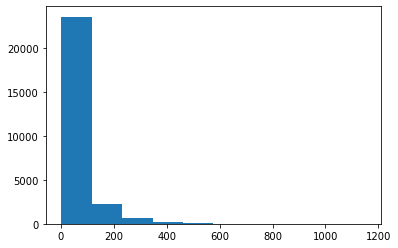

In [32]:
plt.hist(iaps.groupby('AppsFlyer ID')['Event Name'].count())

In [52]:
trials = iaps[iaps['Event Name']=='subscription_wk_start_success'][['Event Time','AppsFlyer ID']]
trials.rename(columns={'Event Time':'trialtime'}, inplace=True)

pays = iaps[iaps['Event Name']=='billing_subscription_success'][['Event Time','AppsFlyer ID']]
pays.rename(columns={'Event Time':'paytime'}, inplace=True)

refund = iaps[iaps['Event Name']=='back_billing_refund_subscription'][['Event Time','AppsFlyer ID']]
refund.rename(columns={'Event Time':'refundtime'}, inplace=True)

In [53]:
events = iaps.merge(trials, on='AppsFlyer ID', how='left')
events = events.merge(pays, on='AppsFlyer ID', how='left')
events = events.merge(refund, on='AppsFlyer ID', how='left')

In [57]:
events.groupby(['Media Source','Campaign']).agg({'AppsFlyer ID':'nunique',
                               'trialtime':'nunique',
                               'paytime':'nunique',
                               'refundtime':'nunique'})

AppsFlyer ID  \
Media Source        Campaign                                                           
Facebook Ads        09-10-2020 - RH - Relationships_text - 6                       1   
                    09-22-2020 - AAA - EU 2 - Top creatives - iOS                  1   
                    10-01-2020-Top creatives-iOS - Copy                            1   
                    10-07-2020 - Text_LC_T1 _ Nebula 2                             1   
                    10-09-2020_Viral_Text_Images_IH_IH_FB_14110                    1   
                    LC_08-13-2020_Compatibility_Influencers_new_IH_...             1   
Landing Page        nebulahoroscope.com                                            1   
Social_facebook     10-20-2020_One_link_Text_black_IH                              1   
Social_instagram    Instagram_stories                                              1   
TikTok              None                                                           1   
adaction_int        Nebula - Social Influencer (iPhone/iPad, Free, ...             2   
adsbalance_int      DP_LM_CH                                                     907   
                    DP_LM_US                                                    1316   
                    DP_adsprfc_US                                                650   
                    DP_inm_US                                                     16   
                    TF_BR_MoB                                                    563   
                    TF_CN_MoB                                                    490   
                    TF_CaAu_MoB                                                 4785   
                    TF_CaAu_SALL                                                 973   
                    TF_NZ_MoB                                                    478   
                    TF_US_HW                                                    3047   
                    TF_US_M_ZP                                                     2   
                    TF_US_MoBW                                                  8751   
                    TF_US_MoBsa                                                 1032   
                    TF_US_MoBstr                                                  24   
                    TF_US_Pap                                                   1476   
                    TF_US_Prop_pop3g                                               1   
                    TF_US_RTBD                                                   265   
                    TF_US_S_ZP                                                     3   
                    TF_US_Tap                                                     37   
adtiming_int        TF_t1                                                          8   
bytedanceglobal_int ACO Campaign 20/10                                             1   
                    ACO Campaign 21/10                                             4   
                    ACO Campaign 24/10                                             6   
                    ACO Campaign 25/10                                             2   
                    From ACO 16/10 Tier 1                                          3   
                    From ACO App Background 22/10                                 20   
                    Influencers FR                                                 3   
                    Influencers US f+m                                             2   
                    New Influencers 01.08                                          5   
                    Tier 1 All Influencers 19/10                                   5   
                    Tier 1/[US+CA+AU] Campaign                                     5   
                    influencers AU 19/09                                           1   
ironsource_int      US 15/10 New creatives                                        19   
jetfuelit_int       Nebu

In [59]:
events['beforetrial'] = events[~events.trialtime.isna()][]

ValueError: Wrong number of items passed 22, placement implies 1